# Neural Cellular Automata

## Imports and hyperparameters

In [16]:
# imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pclab.utils import def_device

In [2]:
# hyperparameters
CHANNEL_N = 16
TARGET_PADDING = 16
TARGET_SIZE = 40

POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

## Loading the target image

Image of shape: (40, 40, 4) and type: uint8 with values in range: 0 to 255


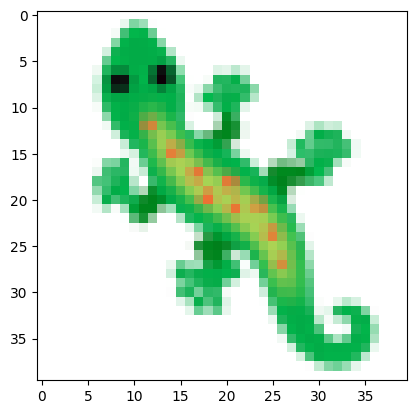

In [3]:
path = 'images/emoji_u1f98e.png'

# Open the image
img = Image.open(path).resize((TARGET_SIZE, TARGET_SIZE))

# Convert the image to numpy array
img = np.array(img)
print(f"Image of shape: {img.shape} and type: {img.dtype} with values in range: {img.min()} to {img.max()}")

# Show the image
plt.imshow(img)
plt.show()


Image of shape: (40, 40, 4) and type: float32 with values in range: 0.0 to 1.0


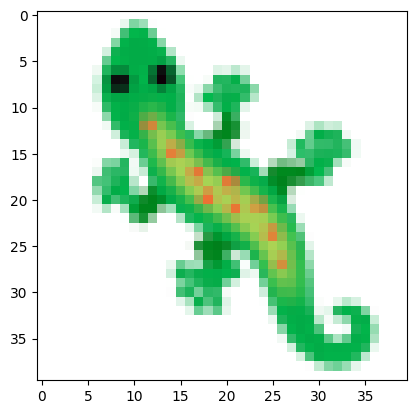

In [4]:
img = img.astype(np.float32) / 255.0
print(f"Image of shape: {img.shape} and type: {img.dtype} with values in range: {img.min()} to {img.max()}")
plt.imshow(img)
plt.show()


## Creating the Model

Defining the filters that we will apply to the image. Instead of applying 2 sobels filters and concatenate the results with the input we use and identity filter as well. 

In [5]:
# According to the paper we apply 3 filters, a horizontal sobel filter, a vertical sobel filter and an identity filter
filters = torch.stack([
    torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),      # Identity filter 
    torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),   # Vertical sobel filter
    torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T  # Horizontal sobel filter
]).to(def_device)

In [6]:
filters

tensor([[[ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  0.]],

        [[-1.,  0.,  1.],
         [-2.,  0.,  2.],
         [-1.,  0.,  1.]],

        [[-1., -2., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  2.,  1.]]], device='cuda:0')

In [7]:
def perchannel_conv(x, filters):
    b, c, h, w = x.shape
    y = x.reshape(b * c, 1, h, w)
    y = F.pad(y, (1, 1, 1, 1), mode='circular')
    y = F.conv2d(y, filters[:, None])
    return y.reshape(b, -1, h, w)

Testing the result of applying the filters in the imput image

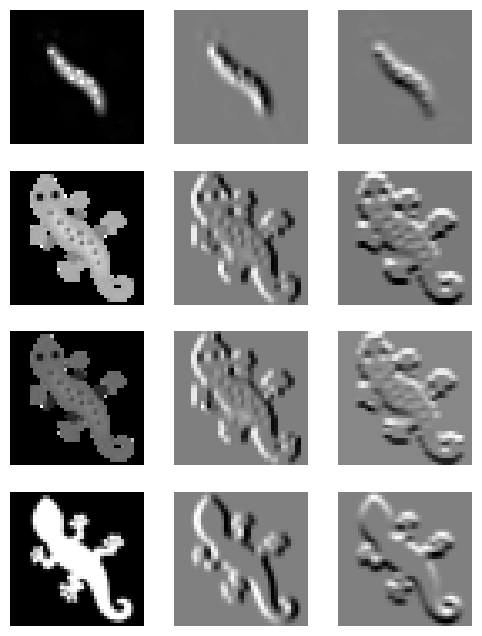

In [8]:
img_tensor = torch.tensor(img).permute(2, 0, 1)[None].to(def_device)
img_filters = perchannel_conv(img_tensor, filters)

# This will result in 3 images, one for each filter (RGBA)
# Visualize all 12 channels in a 4x3 grid
plt.figure(figsize=(6, 8))
for i in range(12):

    plt.subplot(4, 3, i + 1)
    plt.imshow(img_filters[0, i].detach().cpu(), cmap='gray')
    plt.axis('off')


In [9]:
img_filters = torch.cat([img_tensor, img_filters], dim=1)
img_filters.shape


torch.Size([1, 16, 40, 40])

We need a function that will detect the alive cells:

In [10]:
def alive(x, threshold=0.1):
    x = F.pad(x, (1, 1, 1, 1), mode='circular')
    return F.max_pool2d(x, 3, stride=1, padding=0) > threshold

In [27]:
class CAModel(nn.Module):

    def __init__(self, channel_n, update_rate=0.5):
        super(CAModel, self).__init__()
        self.channel_n = channel_n
        self.update_rate = update_rate
        

        self.brain = nn.Sequential(
            nn.Conv2d(channel_n * 3, 128, kernel_size=1), # pixel-wise mlp 
            nn.ReLU(),
            nn.Conv2d(128, self.channel_n, kernel_size=1, bias=False)
        )

        # this network is used to calculate the change of the features, so initially, we dont want to suggest any changes
        # thus we set the output weights to zero
        with torch.no_grad():
            self.brain[-1].weight.zero_()


    def step(self, x, update_rate=None):
                
        # -- Perception -- (apply the filters to the input)
        y = perchannel_conv(x, filters)

        
        # -- Update Rule -- (pass the input through the brain)
        y = self.brain(y)

        # -- Stochastic cell update --
        B, C, H, W = y.shape
        update_rate = update_rate or self.update_rate # if update_rate is not given, use the default value
        update_mask = (torch.rand(B, 1, H, W).to(def_device) + update_rate).floor() 
        x = x + y * update_mask # update only a fraction of the cells

        # -- Alive masking --
        alive_mask = alive(x[:, 3:4, :, :], threshold=0.1) # we use 3:4 to keep the dimension
        x = x * alive_mask

        return x

    def forward(self, x, steps=1, update_rate=None):
        for i in range(steps):
            x = self.step(x, update_rate=update_rate)
        return x
    

## Experiment 1: Learning to Grow

Create a grid with zeros, except a single cell in the center, which will have all channels, except RGB, set to 1. 

*We set the RGB channels of the seed to zero because we want it to be visible on the white background.*

In [12]:
seed = torch.zeros(1, 16, TARGET_SIZE, TARGET_SIZE).to(def_device)
seed[:, 3:, TARGET_SIZE//2, TARGET_SIZE//2] = 1.0

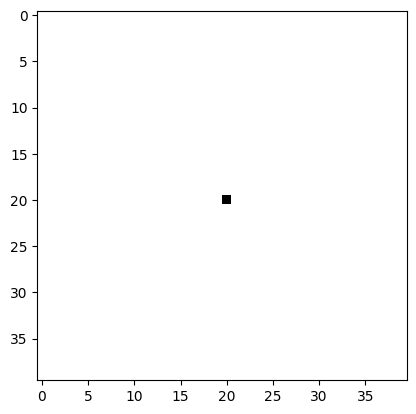

In [13]:
plt.imshow(seed[0, :4].detach().cpu().permute(1, 2, 0))
plt.show()

We also sample a random number of CA steps from the [64, 96] range. 

*This should be a sufficient number of steps to grow the pattern of the size we work with (40x40), even considering the stochastic nature of our update rule.*

In [49]:
from tqdm import tqdm
n_epochs = 50 #8000
batch_size = 8

ca = CAModel(CHANNEL_N).to(def_device)


lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
optimizer = torch.optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

input = seed.repeat(batch_size, 1, 1, 1)
target = img_tensor.repeat(batch_size, 1, 1, 1)

for i in tqdm(range(n_epochs)):

    steps = torch.randint(64, 96, (1,)).item()
    res = ca(input, steps=steps)

    loss = F.mse_loss(res[:, :4], target) # we only care about the RGBA channels
    print(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()


  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:00<00:03, 13.79it/s]

tensor(0.1132, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1346, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1052, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 4/50 [00:00<00:03, 12.53it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 8/50 [00:00<00:03, 12.03it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 10/50 [00:00<00:03, 12.11it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 14/50 [00:01<00:02, 12.18it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 16/50 [00:01<00:02, 12.29it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 20/50 [00:01<00:02, 12.05it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 22/50 [00:01<00:02, 12.12it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 26/50 [00:02<00:02, 11.93it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 30/50 [00:02<00:01, 12.16it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 32/50 [00:02<00:01, 12.04it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 36/50 [00:02<00:01, 12.91it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 38/50 [00:03<00:00, 13.03it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 42/50 [00:03<00:00, 12.92it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 44/50 [00:03<00:00, 12.85it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 46/50 [00:03<00:00, 12.98it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 50/50 [00:04<00:00, 12.39it/s]

tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<MseLossBackward0>)


In [42]:
res.shape, target.shape

(torch.Size([8, 16, 40, 40]), torch.Size([8, 4, 40, 40]))

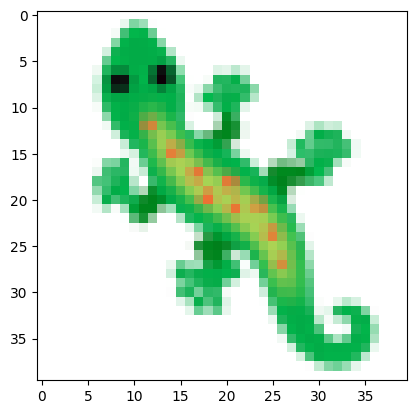

In [46]:
plt.imshow(target[0, :4].detach().cpu().permute(1, 2, 0))
plt.show()

True